Repeat exercise 15 of Part 2 (text classification with mostly linear classifiers), now using
an MLP classifier implemented (by you) in TensorFlow.

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install --upgrade tensorflow

In [3]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [4]:
!nvidia-smi

Wed Nov 22 12:52:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [5]:
import time
import numpy as np
import pandas as pd
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model


In [6]:
from prettytable import PrettyTable

# Dataset

In [7]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvzf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [8]:
def load_train_test_imdb_data(data_dir):
    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
    print(data["train"])
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])
    print(data["test"])
    return data["train"], data["test"]


In [9]:
import os

train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

                                                    text  sentiment
0      We have an average family. Dad's a famous rapp...          0
1      Victor Nunez imbues this unsentimental tale of...          1
2      If you have any kind of heart and compassion f...          1
3      Who doesn't have unresolved issues with parent...          1
4      I recently viewed Manufactured Landscapes at t...          0
...                                                  ...        ...
24995  One of my favorite shows back in the '70s. As ...          1
24996  A Chinese Ghost Story stars the late, great Le...          1
24997  "Spin it!"<br /><br />The 90s opened up with a...          1
24998  I love low budget independent films and had hi...          0
24999  I reflect back to the days when I held my boyf...          1

[25000 rows x 2 columns]
                                                    text  sentiment
0      The Monkees, surprisingly, are a big favorite ...          1
1      Better than I e

In [10]:
train_data

,text,sentiment
0,We have an average family. Dad's a famous rapp...,0
1,Victor Nunez imbues this unsentimental tale of...,1
2,If you have any kind of heart and compassion f...,1
3,Who doesn't have unresolved issues with parent...,1
4,I recently viewed Manufactured Landscapes at t...,0
...,...,...
24995,One of my favorite shows back in the '70s. As ...,1
24996,"A Chinese Ghost Story stars the late, great Le...",1
24997,"""Spin it!""<br /><br />The 90s opened up with a...",1
24998,I love low budget independent films and had hi...,0


In [11]:
test_data

,text,sentiment
0,"The Monkees, surprisingly, are a big favorite ...",1
1,Better than I expected from a film selling its...,1
2,The brief existence of The Sex Pistols and the...,0
3,This is yet another gem from the pen of Daniel...,1
4,I wish there was a category to place this in o...,1
...,...,...
24995,"Talk Radio is of course, probably not the most...",1
24996,This movie was boring. Very much like Underwor...,0
24997,So funny is the perfect way to describe this 1...,1
24998,I have seen previous movies from Cédric Klapis...,0


In [12]:
df = pd.concat([train_data, test_data], ignore_index=True)
df

,text,sentiment
0,We have an average family. Dad's a famous rapp...,0
1,Victor Nunez imbues this unsentimental tale of...,1
2,If you have any kind of heart and compassion f...,1
3,Who doesn't have unresolved issues with parent...,1
4,I recently viewed Manufactured Landscapes at t...,0
...,...,...
49995,"Talk Radio is of course, probably not the most...",1
49996,This movie was boring. Very much like Underwor...,0
49997,So funny is the perfect way to describe this 1...,1
49998,I have seen previous movies from Cédric Klapis...,0


In [13]:
x = df['text']
y = df['sentiment']

In [14]:
x

0        We have an average family. Dad's a famous rapp...
1        Victor Nunez imbues this unsentimental tale of...
2        If you have any kind of heart and compassion f...
3        Who doesn't have unresolved issues with parent...
4        I recently viewed Manufactured Landscapes at t...
                               ...                        
49995    Talk Radio is of course, probably not the most...
49996    This movie was boring. Very much like Underwor...
49997    So funny is the perfect way to describe this 1...
49998    I have seen previous movies from Cédric Klapis...
49999    Beyond The Clouds is a hauntingly beautiful, e...
Name: text, Length: 50000, dtype: object

In [15]:
y

0        0
1        1
2        1
3        1
4        0
        ..
49995    1
49996    0
49997    1
49998    0
49999    1
Name: sentiment, Length: 50000, dtype: int64

# **Pre-Processing**

In [16]:
import nltk
nltk.download('wordnet')

import re
# Consult python regex docs for Regular Expression usage: https://docs.python.org/3/library/re.html

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
stemmer = WordNetLemmatizer()
docs = []

for doc in x:

    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I) #re.I -> ignore case

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    word_list = document.split()

    # Lemmatization
    word_list = [stemmer.lemmatize(word) for word in word_list]

    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(word_list)

    # Append all documents into a list 'docs'
    docs.append(document)

In [18]:
print("\nOriginal review text:\n{}".format(x[0]))
print("\nFiltered review text:\n{}".format(docs[0]))
print("\nLabel:\n", y[0])


Original review text:
We have an average family. Dad's a famous rapper, we have the "rebelious teenage daughter", the adopted white kid, and the cute little kid. And we have careless housemaid, what show has had a housemaid like that? Do we have a messed-up Brady Bunch? Yay! When it first came out I thought it was really cool, mostly because I was young. The music was bad. The raps were so bad and they were too g-rated. All of his raps were about his family and friends and problems. The dad was kind of the "Danny from Full House" type of dad. Always gave the advice out. But he wasn't a clean freak. They had a house-keeper for that. Remember? The plots were basically Lil' Romeo was in trouble of some sort, or... not that's it. Oh and maybe some preteen drama. Yeah that stuff is good. Not really. But its still a good show for kids. But Nikelodean could do better.

Filtered review text:
we have an average family dad a famous rapper we have the rebelious teenage daughter the adopted white

# **Split dataset**
In the data preprocessing phase, the dataset was partitioned into training, development, and test sets using the train_test_split function from the scikit-learn library, ensuring a representative distribution of sentiment across the subsets. This systematic division allowed for independent model training on the training set, hyperparameter tuning on the development set, and unbiased evaluation on the test set, fostering a robust analysis of model generalization.

## Training Set

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.3, random_state=23828748)

In [20]:
len(x_train)

35000

## Development Set

In [21]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [22]:
len(x_dev)

5250

In [23]:
# Calculate the number of documents in each set
num_training_documents = len(x_train)
num_dev_documents = len(x_dev)
num_test_documents = len(x_test)

# Print he results
print(f"Number of Training Documents: {num_training_documents}")
print(f"Number of Development Documents: {num_dev_documents}")
print(f"Number of Test Documents: {num_test_documents}")

Number of Training Documents: 29750
Number of Development Documents: 5250
Number of Test Documents: 15000


## Test Set

In [24]:
len(x_test)

15000

# Tokenization

In [25]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer')

def tokenize_text(text):
    doc = nlp(text)  # Tokenize the text into sentences
    tokens = []

    for sent in doc.sents:
        for tok in sent:  # Iterate through the words of the sentence
            # Skip non-useful tokens
            if (
                '\n' in tok.text or
                "\t" in tok.text or
                "--" in tok.text or
                "*" in tok.text or
                tok.text.lower() in STOP_WORDS
            ):
                continue

            if tok.text.strip():
                tokens.append(tok.text.replace('"', "'").strip())

    return tokens

In [26]:
X_train_tokenized = [tokenize_text(text) for text in x_train]
X_dev_tokenized = [tokenize_text(text) for text in x_dev]
X_test_tokenized = [tokenize_text(text) for text in x_test]

In [27]:
for item in X_train_tokenized[:2]:
  print(item, '\n')

['doesn', 'promising', 'long', 'stretch', 'renoir', 'french', 'cancan', 'end', 'effortlessly', 'charming', 'film', 'story', 'cliché', 'laundry', 'girl', 'nini', 'françoise', 'arnoul', 'discovered', 'night', 'club', 'owner', 'danglard', 'jean', 'gabin', 'danglard', 'steal', 'baker', 'boyfriend', 'drop', 'current', 'girlfriend', 'come', 'lover', 'nini', 'ha', 'choose', 'humble', 'life', 'baker', 'employer', 'oh', 'princess', 'prince', 'fall', 'love', 'point', 'm', 'glad', 'film', 'didn', 'obvious', 'choice', 'lesser', 'film', 'certainly', 'film', 'end', 'opening', 'danglard', 'new', 'night', 'club', 'moulin', 'rouge', 'couple', 'gorgeous', 'song', 'dance', 'number', 'complainte', 'de', 'la', 'butte', 'provides', 'base', 'film', 'musical', 'score', 'simply', 'gorgeous', 'song', 'written', 'renoir', 'wrote', 'fan', 'baz', 'luhrmann', '2001', 'film', 'moulin', 'rouge', 'll', 'recognize', 'tune', 'come', 'near', 'beginning', 'film', 'sung', 'rufus', 'wainwright', 'isn', 'prominent', 'film', 

# Training Preparation

## TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use unigram & bi-gram tf*idf features
# Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_dev_tfidf = vectorizer.transform([" ".join(x) for x in X_dev_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

print(X_train_tfidf.shape)

(29750, 5000)


## SVD

In [29]:
# Reduce dimensionality using svd 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_dev_svd = svd.transform(X_dev_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(X_train_svd.shape)

(29750, 500)


## 1-hot Vectors

In [30]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
target_list = [0,1]

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_dev_1_hot = lb.transform([target_list[x] for x in y_dev])
# y_test_1_hot = lb.transform([target_list[x] for x in y_test])

print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))
print('y_dev_1_hot[0]: {}'.format(y_dev_1_hot[0]))

y_train_1_hot[0]: [1]
y_dev_1_hot[0]: [1]


# Evaluation Preparation

In [31]:
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

# Baseline Models

In [32]:
# Define target names based on your specific class labels
target_names = ["0", "1"]

## Majority Classifier

In [33]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Create a majority classifier that always predicts the most frequent class
majority_classifier = DummyClassifier(strategy="most_frequent")
majority_classifier.fit(X_train_svd, y_train)

# Make predictions on the development set
predictions_majority = majority_classifier.predict(X_dev_svd)

# Print the classification report for the majority classifier
print(classification_report(y_dev, predictions_majority, target_names=target_names))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2645
           1       0.50      1.00      0.66      2605

    accuracy                           0.50      5250
   macro avg       0.25      0.50      0.33      5250
weighted avg       0.25      0.50      0.33      5250



In [34]:
from sklearn.metrics import accuracy_score
predictions = majority_classifier.predict(X_dev_svd)
print(f'Validation Accuracy: {accuracy_score(y_dev, predictions)*100:.2f}%')

predictions = majority_classifier.predict(X_test_svd)
print(f'Test Accuracy:{accuracy_score(y_test, predictions)*100:.2f}%')

Validation Accuracy: 49.62%
Test Accuracy:49.34%


## Logistic Regression - Lasso
The best classifier from exercise 15 of Part 2.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

best_lambda = 1

clf = LogisticRegression(C=1/best_lambda,penalty='l2')
clf.fit(X_train_svd, y_train)

predictions = clf.predict(X_dev_svd)
print(classification_report(y_dev, predictions, target_names=target_names))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      2645
           1       0.86      0.89      0.87      2605

    accuracy                           0.87      5250
   macro avg       0.87      0.87      0.87      5250
weighted avg       0.87      0.87      0.87      5250



In [36]:
from sklearn.metrics import accuracy_score
predictions = clf.predict(X_dev_svd)
print(f'Validation Accuracy: {accuracy_score(y_dev, predictions)*100:.2f}%')

predictions = clf.predict(X_test_svd)
print(f'Test Accuracy:{accuracy_score(y_test, predictions)*100:.2f}%')

Validation Accuracy: 87.22%
Test Accuracy:87.62%


# MLP Classifier

In [37]:
print("X_train_svd shape:", X_train_svd.shape)
print("y_train_1_hot shape:", y_train_1_hot.shape)


X_train_svd shape: (29750, 500)
y_train_1_hot shape: (29750, 1)


In [38]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):
    input_dim = X_train_svd.shape[1]

    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))


    # Print model summary to verify the architecture
    print(model.summary())

    # Configures the model for training.
    model.compile(
        loss='binary_crossentropy',  # Change to binary_crossentropy
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')

    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(
        'checkpoints/weights.hdf5',
        monitor='val_accuracy',
        mode='max',
        verbose=2,
        save_best_only=True,
        save_weights_only=True
    )

    start_training_time = time.time()
    history = model.fit(
        X_train_svd,
        y_train_1_hot,
        validation_data=(X_dev_svd, y_dev_1_hot),
        batch_size=256,
        epochs=100,
        shuffle=True,
        callbacks=[checkpoint]
    )
    end_training_time = time.time()

    print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               64128     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 72449 (283.00 KB)
Trainable params: 72449 (283.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
1

## Visualize History

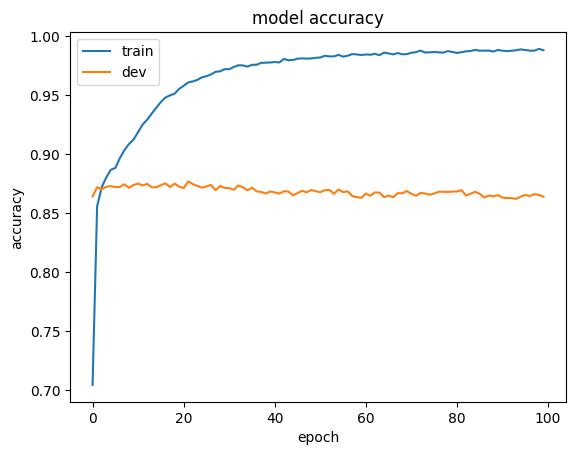

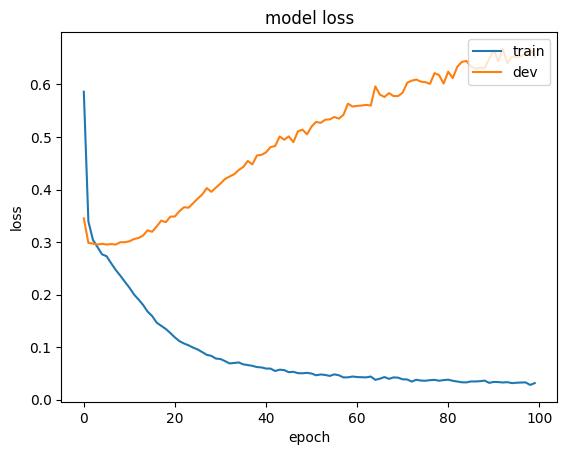

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

As we can see, after 20 epochs, dev loss starts to increase extremely. This fact is an indicator of overfit. That's why we are going to run the model for 20 epochs. \\
However, we also have to tune some hyperparameters too like the number of the hidden layers, the dropout probability and the learning rate too.

In [42]:
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):

    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Load weights from the pre-trained model
    model.load_weights("checkpoints/weights.hdf5")
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=["accuracy"]
        )

    predictions = np.argmax(model.predict(X_dev_svd), -1)
    print(classification_report(y_dev, predictions, target_names=target_names))

165/165 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2645
           1       0.00      0.00      0.00      2605

    accuracy                           0.50      5250
   macro avg       0.25      0.50      0.34      5250
weighted avg       0.25      0.50      0.34      5250



# Hyperparameter Tuning

In [43]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# from kerastuner.tuners import RandomSearch
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import Dense, Dropout
# # from tensorflow.keras.optimizers import Adam

# # # Define the model-building function for Keras Tuner
# # def build_model(hp):
# #     model = Sequential()
# #     model.add(Dense(units=hp.Int('units1', min_value=64, max_value=512, step=32), input_dim=input_dim, activation='relu'))
# #     model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

# #     # Tune the number of layers
# #     num_layers = hp.Int('num_layers', min_value=1, max_value=5)
# #     for i in range(num_layers):
# #         model.add(Dense(units=hp.Int(f'units_layer_{i}', min_value=64, max_value=512, step=32), activation='relu'))
# #         model.add(Dropout(hp.Float(f'dropout_layer_{i}', min_value=0.2, max_value=0.5, step=0.1)))

# #     model.add(Dense(1, activation='sigmoid'))

# #     model.compile(
# #         loss='binary_crossentropy',
# #         optimizer=Adam(learning_rate=0.02),
# #         metrics=["accuracy"]
# #     )

# #     return model
# # Define the model-building function for Keras Tuner
# def build_model(hp):
#     model = Sequential()

#     # Fix the number of units in the first layer
#     units1 = hp.Choice('units1', values=[64, 128, 192, 256])
#     model.add(Dense(units=units1, input_dim=input_dim, activation='relu'))
#     model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

#     # Try specific values for the number of layers
#     num_layers = hp.Choice('num_layers', values=[1,2])
#     for i in range(num_layers):
#         model.add(Dense(units=hp.Int(f'units_layer_{i}', min_value=64, max_value=512, step=32), activation='relu'))
#         model.add(Dropout(hp.Float(f'dropout_layer_{i}', min_value=0.2, max_value=0.5, step=0.1)))

#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(
#         loss='binary_crossentropy',
#         optimizer=Adam(learning_rate=0.02),
#         metrics=["accuracy"]
#     )

#     return model


# # Set up the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,
#     directory='keras_tuner_dir',
#     project_name='my_tuning_experiment'
# )

# # Perform the hyperparameter search
# tuner.search(
#     X_train_svd,
#     y_train_1_hot,
#     validation_data=(X_dev_svd, y_dev_1_hot),
#     epochs=100,
#     batch_size=256
# )

# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.hypermodel.build(best_hp)

# # Train the model with the best hyperparameters
# history = best_model.fit(
#     X_train_svd,
#     y_train_1_hot,
#     validation_data=(X_dev_svd, y_dev_1_hot),
#     epochs=70,
#     batch_size=256
# )

# # Print the summary of the best model
# print(best_model.summary())

# # Save the best model
# best_model.save('best_model.h5')


## Number of Layers - Dropout

## Regularization

In [44]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from kerastuner.tuners import RandomSearch
from tensorflow.keras.regularizers import l1, l2



# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    # model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu'))
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))


    # You can add more layers and dropout rates as needed

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1, sampling='log')),
        # optimizer=Adam(learning_rate=0.0001)
        metrics=["accuracy"]
    )

    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # You can increase this number for a more exhaustive search
    directory='keras_tuner_dir',
    project_name='my_tuning_experiment'
)

# Perform the hyperparameter search
tuner.search(
    X_train_svd,
    y_train_1_hot,
    validation_data=(X_dev_svd, y_dev_1_hot),
    epochs=100,
    batch_size=256
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train_svd,
    y_train_1_hot,
    validation_data=(X_dev_svd, y_dev_1_hot),
    epochs=100,
    batch_size=256
)

# Print the summary of the best model
print(best_model.summary())

# Save the best model
best_model.save('best_model.h5')


Trial 5 Complete [00h 01m 02s]
val_accuracy: 0.847428560256958

Best val_accuracy So Far: 0.8771428465843201
Total elapsed time: 00h 06m 13s
Epoch 1/100
117/117 [==============================] - 2s 8ms/step - loss: 1.9734 - accuracy: 0.5857 - val_loss: 1.6782 - val_accuracy: 0.7143
Epoch 2/100
117/117 [==============================] - 1s 6ms/step - loss: 1.4616 - accuracy: 0.6894 - val_loss: 1.2573 - val_accuracy: 0.7973
Epoch 3/100
117/117 [==============================] - 1s 5ms/step - loss: 1.0897 - accuracy: 0.7698 - val_loss: 0.9131 - val_accuracy: 0.8398
Epoch 4/100
117/117 [==============================] - 1s 4ms/step - loss: 0.7845 - accuracy: 0.8222 - val_loss: 0.6521 - val_accuracy: 0.8543
Epoch 5/100
117/117 [==============================] - 0s 4ms/step - loss: 0.5873 - accuracy: 0.8486 - val_loss: 0.5137 - val_accuracy: 0.8636
Epoch 6/100
117/117 [==============================] - 0s 4ms/step - loss: 0.4822 - accuracy: 0.8634 - val_loss: 0.4432 - val_accuracy: 0.8695
E

In [46]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - Units in the first hidden layer: {best_hp.get('units1')}")
print(f" - Dropout rate in the first hidden layer: {best_hp.get('dropout1')}")
print(f" - Units in the second hidden layer: {best_hp.get('units2')}")
print(f" - Dropout rate in the second hidden layer: {best_hp.get('dropout2')}")
print(f" - Learning rate: {best_hp.get('learning_rate')}")

Best Hyperparameters:
 - Units in the first hidden layer: 96
 - Dropout rate in the first hidden layer: 0.4
 - Units in the second hidden layer: 256
 - Dropout rate in the second hidden layer: 0.2
 - Learning rate: 0.00013452068635548761


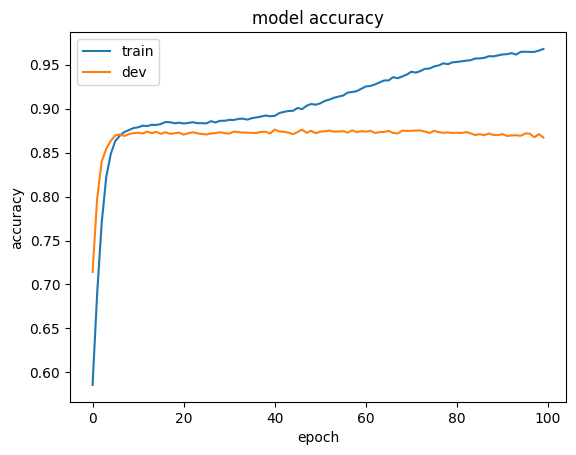

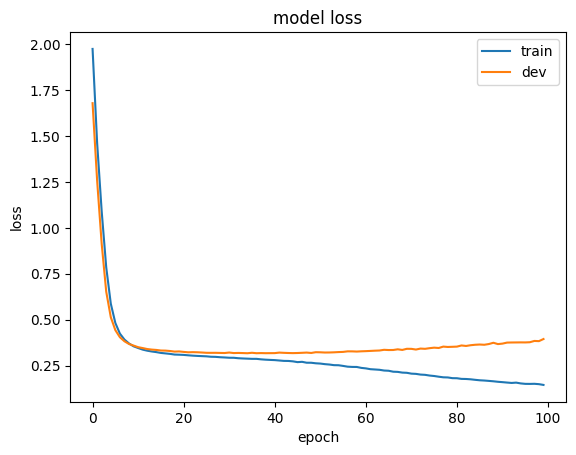

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

## Number of Epochs

As we can see, after 70 epochs, the dev loss is increased. So we have to end the training process in 70 epochs

In [48]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from kerastuner.tuners import RandomSearch
from tensorflow.keras.regularizers import l1, l2



# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    # model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu'))
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))


    # You can add more layers and dropout rates as needed

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1, sampling='log')),
        # optimizer=Adam(learning_rate=0.0001)
        metrics=["accuracy"]
    )

    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # You can increase this number for a more exhaustive search
    directory='keras_tuner_dir',
    project_name='my_tuning_experiment'
)

# Perform the hyperparameter search
tuner.search(
    X_train_svd,
    y_train_1_hot,
    validation_data=(X_dev_svd, y_dev_1_hot),
    epochs=100,
    batch_size=256
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train_svd,
    y_train_1_hot,
    validation_data=(X_dev_svd, y_dev_1_hot),
    epochs=70,
    batch_size=256
)

# Print the summary of the best model
print(best_model.summary())

# Save the best model
best_model.save('best_stopping_model.h5')


Reloading Tuner from keras_tuner_dir/my_tuning_experiment/tuner0.json
Epoch 1/70
117/117 [==============================] - 2s 5ms/step - loss: 1.9823 - accuracy: 0.5505 - val_loss: 1.6876 - val_accuracy: 0.6703
Epoch 2/70
117/117 [==============================] - 1s 4ms/step - loss: 1.4723 - accuracy: 0.6646 - val_loss: 1.2735 - val_accuracy: 0.7646
Epoch 3/70
117/117 [==============================] - 0s 4ms/step - loss: 1.1109 - accuracy: 0.7509 - val_loss: 0.9350 - val_accuracy: 0.8375
Epoch 4/70
117/117 [==============================] - 1s 5ms/step - loss: 0.7955 - accuracy: 0.8216 - val_loss: 0.6545 - val_accuracy: 0.8518
Epoch 5/70
117/117 [==============================] - 1s 6ms/step - loss: 0.5856 - accuracy: 0.8482 - val_loss: 0.5104 - val_accuracy: 0.8659
Epoch 6/70
117/117 [==============================] - 1s 6ms/step - loss: 0.4797 - accuracy: 0.8639 - val_loss: 0.4409 - val_accuracy: 0.8682
Epoch 7/70
117/117 [==============================] - 1s 6ms/step - loss: 0.42

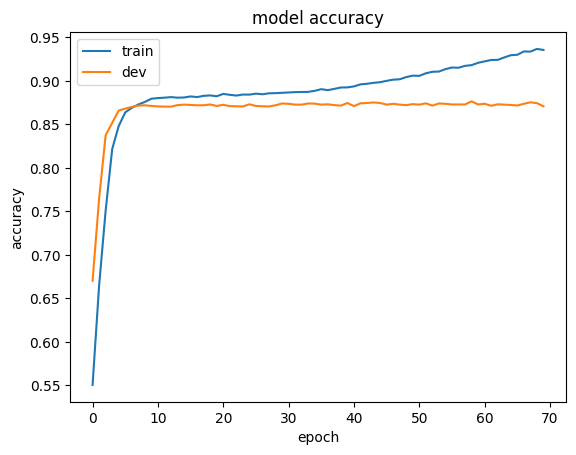

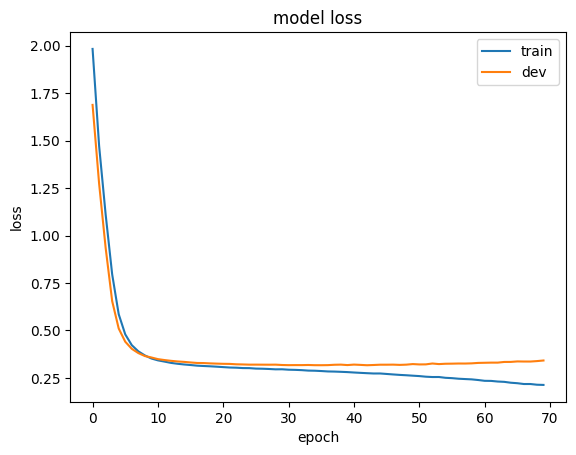

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

## Performance

In [50]:
test_loss, test_accuracy = best_model.evaluate(X_test_svd, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

469/469 [==============================] - 2s 5ms/step - loss: 0.3311 - accuracy: 0.8763
Test Loss: 0.3311, Test Accuracy: 0.8763


In [51]:
from sklearn.metrics import accuracy_score

dev_predictions = (best_model.predict(X_dev_svd) >= 0.5).astype(int)
test_predictions = (best_model.predict(X_test_svd) >= 0.5).astype(int)

dev_accuracy = accuracy_score(y_dev, dev_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f'Devidation Accuracy: {dev_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

469/469 [==============================] - 2s 4ms/step
Devidation Accuracy: 87.09%
Test Accuracy: 87.63%


# Metrics

In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve
import matplotlib.pyplot as plt

classifiers = [majority_classifier, clf, best_model]
classifier_names = ["Majority Classifier", "Logistic Regression - Lasso", "Best Model"]

In [53]:
classes = [0,1]

## Precision - Recall - F1 - AUC

In [72]:
# from prettytable import PrettyTable
# from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# # Assuming classifiers, classifier_names, classes, x_train_selected, x_dev_selected, x_test_selected,
# # y_train, y_dev, y_test are defined

# # Initialize an empty list to store tables
# tables = []

# # Loop through each classifier
# for classifier, classifier_name in zip(classifiers, classifier_names):
#     # Initialize an empty PrettyTable for the current classifier
#     table = PrettyTable()

#     table.field_names = ['Class', 'Precision (Train)', 'Recall (Train)', 'F1 (Train)', 'PR-AUC (Train)',
#                          'Precision (Dev)', 'Recall (Dev)', 'F1 (Dev)', 'PR-AUC (Dev)',
#                          'Precision (Test)', 'Recall (Test)', 'F1 (Test)', 'PR-AUC (Test)']

#     # Loop through each class
#     for class_name in classes:
#         # Initialize an empty list to store metrics for the current class
#         metrics = []

#         # Loop through each subset (training, development, test)
#         for subset_name, y_true, X in [('Training', y_train, X_train_svd),
#                                        ('Development', y_dev, X_dev_svd),
#                                        ('Test', y_test, X_test_svd)]:
#             # Filter data for the current class
#             y_true_class = (y_true == class_name)

#             if hasattr(classifier, 'predict_proba'):  # For classifiers with predict_proba
#                 y_pred_prob = classifier.predict_proba(X)[:, 1]
#                 y_pred_class = (y_pred_prob >= 0.5).astype(int)
#             else:  # For classifiers without predict_proba (like MLP)
#                 y_pred_prob = classifier.predict(X).ravel()
#                 y_pred_class = (y_pred_prob >= 0.5).astype(int)

#             precision = precision_score(y_true_class, y_pred_class)
#             recall = recall_score(y_true_class, y_pred_class)
#             f1 = f1_score(y_true_class, y_pred_class)
#             pr_auc = average_precision_score(y_true_class, y_pred_prob)

#             metrics.extend([precision, recall, f1, pr_auc])

#         table.add_row([class_name] + metrics)

#     # Append the table to the list of tables
#     tables.append(f"Classifier: {classifier_name}\n{table}")

# # Print the tables
# for table_str in tables:
#     print(table_str)


In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Assuming classifiers, classifier_names, classes, X_train_svd, X_dev_svd, X_test_svd,
# y_train, y_dev, y_test are defined

# Initialize an empty list to store tables
tables = []

# Loop through each classifier
for classifier, classifier_name in zip(classifiers, classifier_names):
    # Initialize empty DataFrames for training, development, and test
    train_table = pd.DataFrame(columns=['Class', 'Precision', 'Recall', 'F1', 'PR-AUC'])
    dev_table = pd.DataFrame(columns=['Class', 'Precision', 'Recall', 'F1', 'PR-AUC'])
    test_table = pd.DataFrame(columns=['Class', 'Precision', 'Recall', 'F1', 'PR-AUC'])

    # Loop through each class
    for class_name in classes:
        # Initialize an empty list to store metrics for the current class
        metrics_train = []
        metrics_dev = []
        metrics_test = []

        # Loop through each subset (training, development, test)
        for subset_name, y_true, X in [('Training', y_train, X_train_svd),
                                       ('Development', y_dev, X_dev_svd),
                                       ('Test', y_test, X_test_svd)]:
            # Filter data for the current class
            y_true_class = (y_true == class_name)

            if hasattr(classifier, 'predict_proba'):  # For classifiers with predict_proba
                y_pred_prob = classifier.predict_proba(X)[:, 1]
                y_pred_class = (y_pred_prob >= 0.5).astype(int)
            else:  # For classifiers without predict_proba (like MLP)
                y_pred_prob = classifier.predict(X).ravel()
                y_pred_class = (y_pred_prob >= 0.5).astype(int)

            precision = precision_score(y_true_class, y_pred_class)
            recall = recall_score(y_true_class, y_pred_class)
            f1 = f1_score(y_true_class, y_pred_class)
            pr_auc = average_precision_score(y_true_class, y_pred_prob)

            # Append the metrics for each subset
            if subset_name == 'Training':
                metrics_train.extend([class_name, precision, recall, f1, pr_auc])
            elif subset_name == 'Development':
                metrics_dev.extend([class_name, precision, recall, f1, pr_auc])
            elif subset_name == 'Test':
                metrics_test.extend([class_name, precision, recall, f1, pr_auc])

        # Append the metrics to the corresponding DataFrame
        train_table = train_table.append(pd.Series(metrics_train, index=train_table.columns), ignore_index=True)
        dev_table = dev_table.append(pd.Series(metrics_dev, index=dev_table.columns), ignore_index=True)
        test_table = test_table.append(pd.Series(metrics_test, index=test_table.columns), ignore_index=True)

    tables.append((f"Classifier: {classifier_name}", train_table, dev_table, test_table))

# Print the tables
for table_str, train_df, dev_df, test_df in tables:
    print(table_str)
    print("Training Table:")
    print(train_df)
    print("\nDevelopment Table:")
    print(dev_df)
    print("\nTest Table:")
    print(test_df)
    print("\n")


469/469 [==============================] - 1s 2ms/step
Classifier: Majority Classifier
Training Table:
   Class  Precision  Recall        F1  PR-AUC
0    0.0      0.496     1.0  0.663102   0.496
1    1.0      0.504     1.0  0.670213   0.504

Development Table:
   Class  Precision  Recall        F1   PR-AUC
0    0.0    0.50381     1.0  0.670044  0.50381
1    1.0    0.49619     1.0  0.663272  0.49619

Test Table:
   Class  Precision  Recall        F1  PR-AUC
0    0.0     0.5066     1.0  0.672508  0.5066
1    1.0     0.4934     1.0  0.660774  0.4934


Classifier: Logistic Regression - Lasso
Training Table:
   Class  Precision    Recall        F1    PR-AUC
0    0.0   0.124716  0.130320  0.127457  0.307643
1    1.0   0.875284  0.900093  0.887515  0.952481

Development Table:
   Class  Precision    Recall        F1    PR-AUC
0    0.0   0.141054  0.143667  0.142349  0.314985
1    1.0   0.858946  0.888292  0.873372  0.943068

Test Table:
   Class  Precision    Recall        F1    PR-AUC
0    0

## Macro - Metrics

In [74]:
# from prettytable import PrettyTable
# from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# # Assuming classifiers, classifier_names, classes, X_train_svd, X_dev_svd, X_test_svd,
# # y_train, y_dev, y_test are defined

# # Initialize an empty list to store tables
# tables = []

# # Loop through each classifier
# for classifier, classifier_name in zip(classifiers, classifier_names):
#     # Initialize an empty PrettyTable for the current classifier
#     table = PrettyTable()

#     table.field_names = ['Class', 'Precision (Train)', 'Recall (Train)', 'F1 (Train)', 'PR-AUC (Train)',
#                          'Precision (Dev)', 'Recall (Dev)', 'F1 (Dev)', 'PR-AUC (Dev)',
#                          'Precision (Test)', 'Recall (Test)', 'F1 (Test)', 'PR-AUC (Test)']

#     # Initialize lists to store scores for macro averaging
#     macro_precision_train = []
#     macro_recall_train = []
#     macro_f1_train = []
#     macro_pr_auc_train = []

#     macro_precision_dev = []
#     macro_recall_dev = []
#     macro_f1_dev = []
#     macro_pr_auc_dev = []

#     macro_precision_test = []
#     macro_recall_test = []
#     macro_f1_test = []
#     macro_pr_auc_test = []

#     # Loop through each class
#     for class_name in classes:
#         # Initialize an empty list to store metrics for the current class
#         metrics_train = []
#         metrics_dev = []
#         metrics_test = []

#         # Loop through each subset (training, development, test)
#         for subset_name, y_true, X in [('Training', y_train, X_train_svd),
#                                        ('Development', y_dev, X_dev_svd),
#                                        ('Test', y_test, X_test_svd)]:
#             # Filter data for the current class
#             y_true_class = (y_true == class_name)

#             if hasattr(classifier, 'predict_proba'):  # For classifiers with predict_proba
#                 y_pred_prob = classifier.predict_proba(X)[:, 1]
#                 y_pred_class = (y_pred_prob >= 0.5).astype(int)
#             else:  # For classifiers without predict_proba (like MLP)
#                 y_pred_prob = classifier.predict(X).ravel()
#                 y_pred_class = (y_pred_prob >= 0.5).astype(int)

#             precision = precision_score(y_true_class, y_pred_class)
#             recall = recall_score(y_true_class, y_pred_class)
#             f1 = f1_score(y_true_class, y_pred_class)
#             pr_auc = average_precision_score(y_true_class, y_pred_prob)

#             if subset_name == 'Training':
#                 metrics_train.extend([precision, recall, f1, pr_auc])
#             elif subset_name == 'Development':
#                 metrics_dev.extend([precision, recall, f1, pr_auc])
#             elif subset_name == 'Test':
#                 metrics_test.extend([precision, recall, f1, pr_auc])

#         # Append the scores for macro-averaging
#         macro_precision_train.append(metrics_train[0])
#         macro_recall_train.append(metrics_train[1])
#         macro_f1_train.append(metrics_train[2])
#         macro_pr_auc_train.append(metrics_train[3])

#         macro_precision_dev.append(metrics_dev[0])
#         macro_recall_dev.append(metrics_dev[1])
#         macro_f1_dev.append(metrics_dev[2])
#         macro_pr_auc_dev.append(metrics_dev[3])

#         macro_precision_test.append(metrics_test[0])
#         macro_recall_test.append(metrics_test[1])
#         macro_f1_test.append(metrics_test[2])
#         macro_pr_auc_test.append(metrics_test[3])

#         table.add_row([class_name] + metrics_train + metrics_dev + metrics_test)

#     # Calculate macro-averaged scores for all subsets
#     macro_precision_avg_train = sum(macro_precision_train) / len(classes)
#     macro_recall_avg_train = sum(macro_recall_train) / len(classes)
#     macro_f1_avg_train = sum(macro_f1_train) / len(classes)
#     macro_pr_auc_avg_train = sum(macro_pr_auc_train) / len(classes)

#     macro_precision_avg_dev = sum(macro_precision_dev) / len(classes)
#     macro_recall_avg_dev = sum(macro_recall_dev) / len(classes)
#     macro_f1_avg_dev = sum(macro_f1_dev) / len(classes)
#     macro_pr_auc_avg_dev = sum(macro_pr_auc_dev) / len(classes)

#     macro_precision_avg_test = sum(macro_precision_test) / len(classes)
#     macro_recall_avg_test = sum(macro_recall_test) / len(classes)
#     macro_f1_avg_test = sum(macro_f1_test) / len(classes)
#     macro_pr_auc_avg_test = sum(macro_pr_auc_test) / len(classes)

#     # Append the macro-averaged scores to the table
#     table.add_row(['Macro Avg'] + [macro_precision_avg_train, macro_recall_avg_train, macro_f1_avg_train, macro_pr_auc_avg_train,
#                                    macro_precision_avg_dev, macro_recall_avg_dev, macro_f1_avg_dev, macro_pr_auc_avg_dev,
#                                    macro_precision_avg_test, macro_recall_avg_test, macro_f1_avg_test, macro_pr_auc_avg_test,
#                                    ])

#     # Append the table to the list of tables
#     tables.append(f"Classifier: {classifier_name}\n{table}")

# # Print the tables
# for table_str in tables:
#     print(table_str)



In [73]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Assuming classifiers, classifier_names, classes, X_train_svd, X_dev_svd, X_test_svd,
# y_train, y_dev, y_test are defined

# Initialize an empty list to store DataFrames for each classifier
tables = []

# Loop through each classifier
for classifier, classifier_name in zip(classifiers, classifier_names):
    # Initialize lists to store macro-averaged scores
    macro_precision_train = []
    macro_recall_train = []
    macro_f1_train = []
    macro_pr_auc_train = []

    macro_precision_dev = []
    macro_recall_dev = []
    macro_f1_dev = []
    macro_pr_auc_dev = []

    macro_precision_test = []
    macro_recall_test = []
    macro_f1_test = []
    macro_pr_auc_test = []

    # Initialize an empty DataFrame for the current classifier
    columns = ['Class', 'Precision (Train)', 'Recall (Train)', 'F1 (Train)', 'PR-AUC (Train)',
               'Precision (Dev)', 'Recall (Dev)', 'F1 (Dev)', 'PR-AUC (Dev)',
               'Precision (Test)', 'Recall (Test)', 'F1 (Test)', 'PR-AUC (Test)']

    df = pd.DataFrame(columns=columns)

    # Loop through each class
    for class_name in classes:
        # Initialize an empty list to store metrics for the current class
        metrics_train = []
        metrics_dev = []
        metrics_test = []

        # Loop through each subset (training, development, test)
        for subset_name, y_true, X in [('Training', y_train, X_train_svd),
                                       ('Development', y_dev, X_dev_svd),
                                       ('Test', y_test, X_test_svd)]:
            # Filter data for the current class
            y_true_class = (y_true == class_name)

            if hasattr(classifier, 'predict_proba'):  # For classifiers with predict_proba
                y_pred_prob = classifier.predict_proba(X)[:, 1]
                y_pred_class = (y_pred_prob >= 0.5).astype(int)
            else:  # For classifiers without predict_proba (like MLP)
                y_pred_prob = classifier.predict(X).ravel()
                y_pred_class = (y_pred_prob >= 0.5).astype(int)

            precision = precision_score(y_true_class, y_pred_class)
            recall = recall_score(y_true_class, y_pred_class)
            f1 = f1_score(y_true_class, y_pred_class)
            pr_auc = average_precision_score(y_true_class, y_pred_prob)

            if subset_name == 'Training':
                metrics_train.extend([precision, recall, f1, pr_auc])
            elif subset_name == 'Development':
                metrics_dev.extend([precision, recall, f1, pr_auc])
            elif subset_name == 'Test':
                metrics_test.extend([precision, recall, f1, pr_auc])

        # Append the scores for macro-averaging
        macro_precision_train.append(metrics_train[0])
        macro_recall_train.append(metrics_train[1])
        macro_f1_train.append(metrics_train[2])
        macro_pr_auc_train.append(metrics_train[3])

        macro_precision_dev.append(metrics_dev[0])
        macro_recall_dev.append(metrics_dev[1])
        macro_f1_dev.append(metrics_dev[2])
        macro_pr_auc_dev.append(metrics_dev[3])

        macro_precision_test.append(metrics_test[0])
        macro_recall_test.append(metrics_test[1])
        macro_f1_test.append(metrics_test[2])
        macro_pr_auc_test.append(metrics_test[3])

        # Append the row to the DataFrame
        df = df.append(pd.Series([class_name] + metrics_train + metrics_dev + metrics_test, index=columns), ignore_index=True)

    # Calculate macro-averaged scores for all subsets
    macro_precision_avg_train = sum(macro_precision_train) / len(classes)
    macro_recall_avg_train = sum(macro_recall_train) / len(classes)
    macro_f1_avg_train = sum(macro_f1_train) / len(classes)
    macro_pr_auc_avg_train = sum(macro_pr_auc_train) / len(classes)

    macro_precision_avg_dev = sum(macro_precision_dev) / len(classes)
    macro_recall_avg_dev = sum(macro_recall_dev) / len(classes)
    macro_f1_avg_dev = sum(macro_f1_dev) / len(classes)
    macro_pr_auc_avg_dev = sum(macro_pr_auc_dev) / len(classes)

    macro_precision_avg_test = sum(macro_precision_test) / len(classes)
    macro_recall_avg_test = sum(macro_recall_test) / len(classes)
    macro_f1_avg_test = sum(macro_f1_test) / len(classes)
    macro_pr_auc_avg_test = sum(macro_pr_auc_test) / len(classes)

    # Append the macro-averaged scores to the summary table
    tables.append((f"Classifier: {classifier_name}", df,
                   [macro_precision_avg_train, macro_recall_avg_train, macro_f1_avg_train, macro_pr_auc_avg_train],
                   [macro_precision_avg_dev, macro_recall_avg_dev, macro_f1_avg_dev, macro_pr_auc_avg_dev],
                   [macro_precision_avg_test, macro_recall_avg_test, macro_f1_avg_test, macro_pr_auc_avg_test]))

# Print the summary tables
for classifier_name, df, macro_avg_train, macro_avg_dev, macro_avg_test in tables:
    print(f"\nClassifier: {classifier_name}")
    print("Individual Metrics:")
    print(df.to_string(index=False))
    print("\nMacro-Averaged Metrics:")
    print(pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1', 'PR-AUC'],
                        'Macro Avg (Train)': macro_avg_train,
                        'Macro Avg (Dev)': macro_avg_dev,
                        'Macro Avg (Test)': macro_avg_test}).to_string(index=False))


469/469 [==============================] - 1s 2ms/step

Classifier: Classifier: Majority Classifier
Individual Metrics:
 Class  Precision (Train)  Recall (Train)  F1 (Train)  PR-AUC (Train)  Precision (Dev)  Recall (Dev)  F1 (Dev)  PR-AUC (Dev)  Precision (Test)  Recall (Test)  F1 (Test)  PR-AUC (Test)
   0.0              0.496             1.0    0.663102           0.496          0.50381           1.0  0.670044       0.50381            0.5066            1.0   0.672508         0.5066
   1.0              0.504             1.0    0.670213           0.504          0.49619           1.0  0.663272       0.49619            0.4934            1.0   0.660774         0.4934

Macro-Averaged Metrics:
   Metric  Macro Avg (Train)  Macro Avg (Dev)  Macro Avg (Test)
Precision           0.500000         0.500000          0.500000
   Recall           1.000000         1.000000          1.000000
       F1           0.666657         0.666658          0.666641
   PR-AUC           0.500000         0.500000  

# Performance Comparison Across Models

|Model Name|Val Accuracy|Test Accuracy|
|----------|--------|--|
|Majority Classifier + TF-IDF|49.62%|49.34% |
|Logistic Regression + TF-IDF + L1|87.62%|87.22% |
|MLP + TF-IDF + L1|87.09%|       87.63%    |
